# Semantic variation analysis in LatinISE


Barbara McGillivray

This notebook contains the code for detecting semantic variation in the Latin corpus LatinISe using word embeddings.

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [3]:
!pip install gensim==4.0
!pip install plotly


[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Import libraries

In [4]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import plotly.express as px
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Parameters

I set the parameters of the analysis.

In [5]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [6]:
dir_in = os.path.join("/Users", "barbaramcgillivray", "OneDrive - King's College London", "Research", "2022", "Nexus Linguarum WG4 UC4.2",  "LatinISE")
dir_out = os.path.join("/Users", "barbaramcgillivray", "OneDrive - King's College London", "Research", "2023", "Latin_semantics",  "ICLL", "analysis")

I define the list of all files:

In [7]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [8]:
len(files)

1268

We only want IntraText files:

In [9]:
files = [f for f in files[:] if "IT" in f]
len(files)

670

I read the metadata file , only focus on IT texts written before 900 CE:

In [10]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata_2023_new.csv'), sep = ",")
#metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]
metadata_df = metadata_df[metadata_df['date'] < 900]
metadata_df

,id,title,creator,date,type,file,Unnamed: 6
18,IT-LAT0001,Vulgata VT Genesis,Hieronymus,382.0,prose,lat_0382_IT-LAT0001.txt,1.0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9.0,poetry,lat_-009_IT-LAT0537.txt,NaN
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524.0,prose,lat_0524_IT-LAT0011.txt,NaN
23,IT-LAT0015,Confessiones,"Augustinus, Aurelius",399.0,prose,lat_0399_IT-LAT0015.txt,NaN
24,IT-LAT0016,Regula,"Augustinus, Aurelius",391.0,prose,lat_0391_IT-LAT0016.txt,NaN
...,...,...,...,...,...,...,...
683,IT-LAT0534_1,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116.0,prose,lat_0116_IT-LAT0534_1.txt,NaN
684,IT-LAT0534_2,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116.0,prose,lat_0116_IT-LAT0534_2.txt,NaN
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116.0,prose,lat_0116_IT-LAT0534_3.txt,NaN
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116.0,prose,lat_0116_IT-LAT0534_4.txt,NaN


In [11]:
metadata_df.shape

(385, 7)

In [12]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type', 'file', 'Unnamed: 6'], dtype='object')

In [13]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18      382.0
19       -9.0
20      524.0
23      399.0
24      391.0
        ...  
683     116.0
684     116.0
685     116.0
686     116.0
1265    533.0
Name: date, Length: 385, dtype: float64>

In [14]:
metadata_df.dtypes

id             object
title          object
creator        object
date          float64
type           object
file           object
Unnamed: 6    float64
dtype: object

Convert date to integer

In [15]:
metadata_df['date'] = metadata_df['date'].astype(int)
metadata_df.dtypes

id             object
title          object
creator        object
date            int64
type           object
file           object
Unnamed: 6    float64
dtype: object

In [16]:
metadata_df.head

<bound method NDFrame.head of                 id                          title  \
18      IT-LAT0001             Vulgata VT Genesis   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
23      IT-LAT0015                   Confessiones   
24      IT-LAT0016                         Regula   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382   prose   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
23                                 August

Number of works per year:

In [17]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450    1
-229    1
-199    3
-185    1
-149    2
       ..
 833    2
 838    1
 841    1
 850    4
 871    1
Name: id, Length: 109, dtype: int64

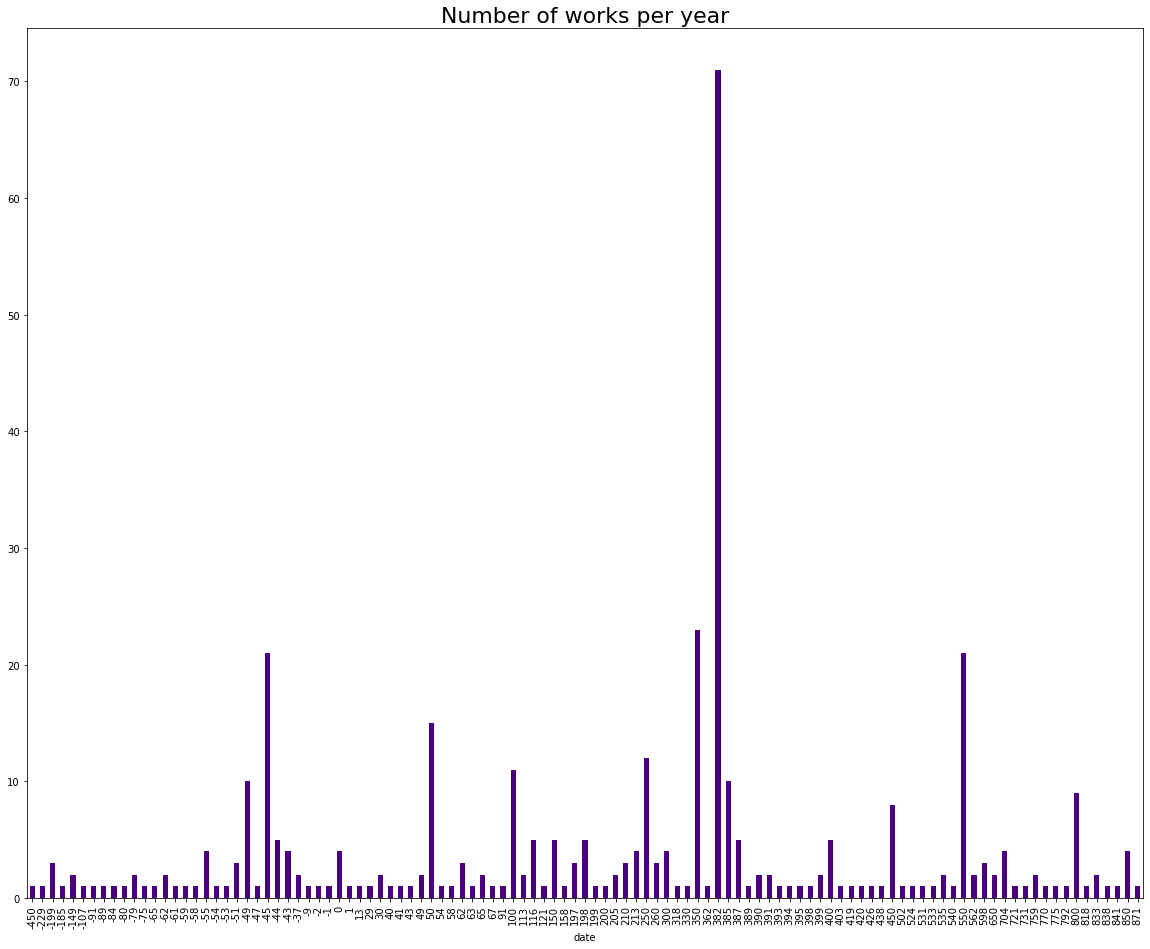

In [18]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

## Split the corpus into subcorpora

### Prose/poetry macro-genres

In this first experiment, we compare prose vs poetry texts. I split the corpus accordingly:

Visualise distribution of subcorpora intervals:

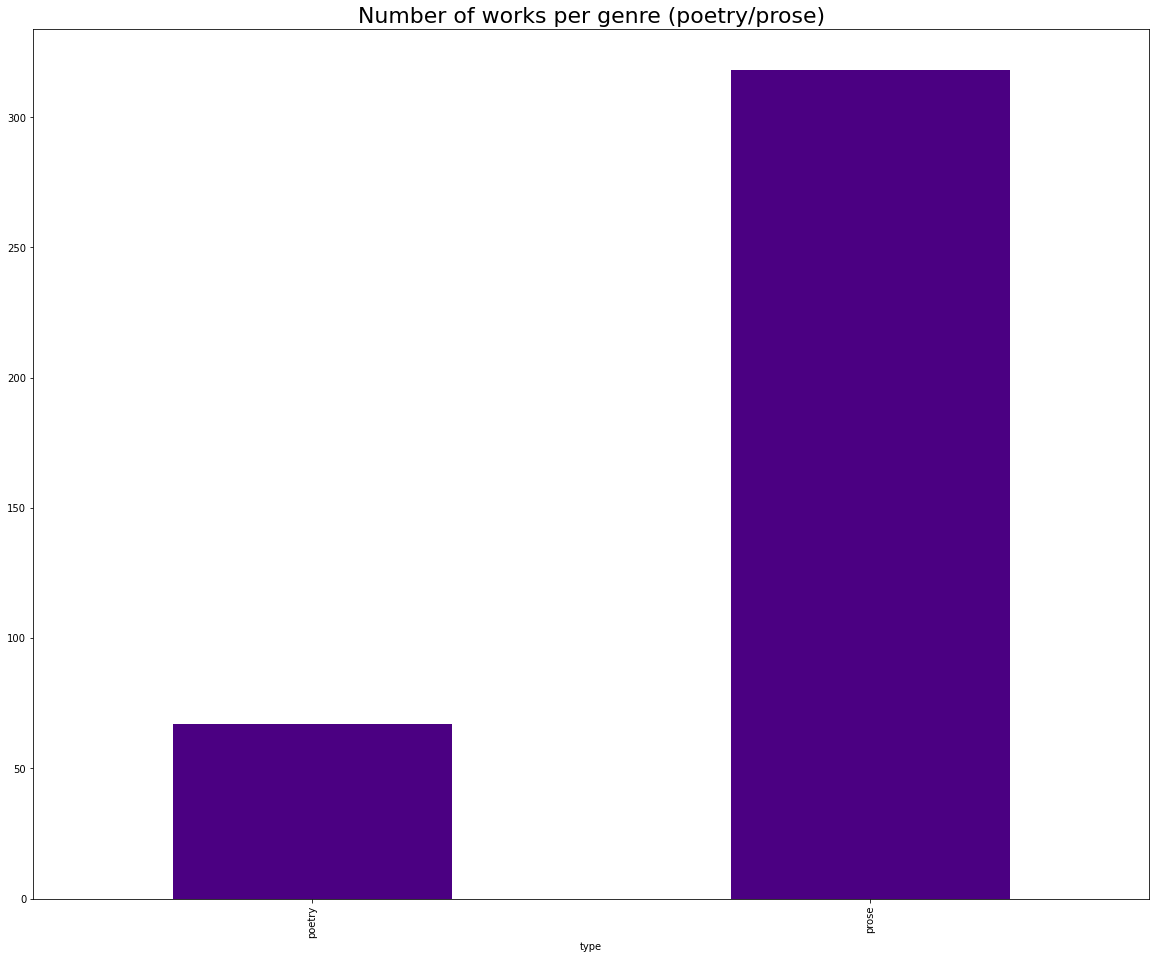

In [19]:
metadata_df0 = metadata_df.groupby(['type']).count()
metadata_df0 = metadata_df0['id']
metadata_df0
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per genre (poetry/prose)", fontsize=22)
plt.show()

In [20]:
metadata_df0

type
poetry     67
prose     318
Name: id, dtype: int64

## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [21]:
def print_vocab(model, top_n = None):
  if model == '':
    print("Empty model!")
  else:
    count = 0
    if top_n is not None:
      for index, word in enumerate(model.wv.index_to_key):
        count+= 1
        if count < top_n:
          print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    else:
      for index, word in enumerate(model.wv.index_to_key):
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [22]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [23]:
punctuation = ['.', ',', '...', ';', ':', '?']

I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [24]:
corpus = list()
files_corpus = metadata_df
for index, df_line in files_corpus.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus.append(sentences_this_file)

3: lat_0382_IT-LAT0001.txt
3: lat_-009_IT-LAT0537.txt
3: lat_0524_IT-LAT0011.txt
3: lat_0399_IT-LAT0015.txt
3: lat_0391_IT-LAT0016.txt
3: lat_-0049_IT-LAT0029.txt
3: lat_0158_IT-LAT0043.txt
3: lat_0049_IT-LAT0045.txt
3: lat_-0045_IT-LAT0047.txt
3: lat_0050_IT-LAT0051.txt
3: lat_0121_IT-LAT0054.txt
3: lat_-0049_IT-LAT0056.txt
3: lat_0199_IT-LAT0058.txt
3: lat_0387_IT-LAT0061.txt
3: lat_0197_IT-LAT0062.txt
3: lat_0050_IT-LAT0563.txt
3: lat_0062_IT-LAT0071.txt
3: lat_0049_IT-LAT0072.txt
3: lat_0063_IT-LAT0073.txt
3: lat_0000_IT-LAT0075.txt
3: lat_0062_IT-LAT0078.txt
3: lat_0058_IT-LAT0079.txt
3: lat_0385_IT-LAT0574.txt
3: lat_0040_IT-LAT0083.txt
3: lat_0385_IT-LAT0574_1.txt
3: lat_0385_IT-LAT0574_2.txt
3: lat_-0080_IT-LAT0093.txt
3: lat_-0079_IT-LAT0094.txt
3: lat_-0061_IT-LAT0095.txt
3: lat_-0051_IT-LAT0096.txt
3: lat_-0043_IT-LAT0097.txt
3: lat_-0043_IT-LAT0098.txt
3: lat_0385_IT-LAT0574_3.txt
3: lat_-0043_IT-LAT0101.txt
3: lat_0000_IT-LAT0102.txt
3: lat_0385_IT-LAT0574_4.txt
3: lat_-00

3: lat_0050_IT-LAT0868.txt
3: lat_0300_IT-LAT0873.txt
3: lat_0550_IT-LAT0875.txt
3: lat_0400_IT-LAT0878.txt
3: lat_0400_IT-LAT0880.txt
3: lat_0030_IT-LAT0883.txt
3: lat_0330_IT-LAT0886.txt
3: lat_0841_IT-LAT0888.txt
3: lat_0260_IT-LAT0893.txt
3: lat_0260_IT-LAT0895.txt
3: lat_0260_IT-LAT0896.txt
3: lat_0450_IT-LAT0904.txt
3: lat_0550_IT-LAT0906.txt
3: lat_0770_IT-LAT0907.txt
3: lat_0598_IT-LAT0908.txt
3: lat_0598_IT-LAT0909.txt
3: lat_0800_IT-LAT0911_7.txt
3: lat_0250_IT-LAT0913.txt
3: lat_0250_IT-LAT0914.txt
3: lat_0150_IT-LAT0916.txt
3: lat_0502_IT-LAT0917.txt
3: lat_0350_IT-LAT0919.txt
3: lat_0850_IT-LAT0920.txt
3: lat_0731_IT-LAT0921.txt
3: lat_-0045_IT-LAT0922_16.txt
3: lat_0067_IT-LAT0934.txt
3: lat_0833_IT-LAT0936.txt
3: lat_-0185_IT-LAT0952.txt
3: lat_-0044_IT-LAT0955.txt
3: lat_-0044_IT-LAT0956.txt
3: lat_0598_IT-LAT0957.txt
3: lat_0250_IT-LAT0959.txt
3: lat_0350_IT-LAT0978.txt
3: lat_0550_IT-LAT0987.txt
3: lat_-0149_IT-LAT0988.txt
3: lat_0550_IT-LAT0990_9.txt
3: lat_-0107_IT-

In [25]:
metadata_df

,id,title,creator,date,type,file,Unnamed: 6
18,IT-LAT0001,Vulgata VT Genesis,Hieronymus,382,prose,lat_0382_IT-LAT0001.txt,1.0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,NaN
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,NaN
23,IT-LAT0015,Confessiones,"Augustinus, Aurelius",399,prose,lat_0399_IT-LAT0015.txt,NaN
24,IT-LAT0016,Regula,"Augustinus, Aurelius",391,prose,lat_0391_IT-LAT0016.txt,NaN
...,...,...,...,...,...,...,...
683,IT-LAT0534_1,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_1.txt,NaN
684,IT-LAT0534_2,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_2.txt,NaN
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,NaN
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,NaN


In [26]:
corpus

[['in', 'principium', 'creo', 'deus', 'caelum', 'et', 'terra'],
 ['terra',
  'autem',
  'sum',
  'inanis',
  'et',
  'vacuus',
  'et',
  'tenebrae',
  'super',
  'facies',
  'abyssus',
  'et',
  'spiritus',
  'deus',
  'fero',
  'super',
  'aqua'],
 ['dico', 'deus', 'fio', 'lux', 'et', 'facio', 'sum', 'lux'],
 ['et',
  'video',
  'deus',
  'lux',
  'quod',
  'sum',
  'bonus',
  'et',
  'divisor',
  'lux',
  'atque',
  'tenebrae'],
 ['appello',
  'lux',
  'dies',
  'et',
  'tenebrae',
  'nox',
  'factumque',
  'sum',
  'vesper',
  'et',
  'mane',
  'dies',
  'unus'],
 ['dico#2',
  'quoque',
  'deus',
  'fio',
  'firmamentum',
  'in',
  'medius',
  'aqua',
  'et',
  'divido',
  'aqua',
  'ab',
  'aqua'],
 ['et',
  'facio',
  'deus',
  'firmamentum',
  'divisitque',
  'aqua',
  'quis#2',
  'sum',
  'sub',
  'firmamentum',
  'ab',
  'hic',
  'quis#2',
  'sum',
  'super',
  'firmamentum',
  'et',
  'facio',
  'sum',
  'ita'],
 ['voco',
  'deus',
  'firmamentum',
  'caelum',
  'et',
  'facio

In [27]:
len(corpus)

318341

Function for training FastText models (from Krzysztof Nowak):

In [28]:
def fasttext(self, opts=dict()):
        """
        Reads sentences from the corpus. Implements:
            https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText
        Returns
        -------
        FastText model
        """
        default_opts = dict(vector_size=100, alpha=0.025,
                            window=5, min_count=5, epochs=5)
        opts_new = default_opts
        for opt in opts.keys():
            opts_new[opt] = opts[opt]
        model = FastText(
            vector_size=opts_new["vector_size"],
            alpha=opts_new["alpha"],
            window=opts_new["window"],
            min_count=opts_new["min_count"])
        model.build_vocab(corpus_iterable=[sentence for sentence in
                                           self.corpus.get_sents()])
        total_examples = model.corpus_count
        model.train(corpus_iterable=[sentence for sentence
                                     in self.corpus.get_sents()],
                    total_examples=total_examples,
                    epochs=opts_new["epochs"])
        return model

Parameters: 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020) or 5 following Sprugnoli et al. (2019).

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [29]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(19539471, 26673700)

Let's see what words are similar to "dies":

In [30]:
model.wv.similar_by_word('dies', 10)

[('hora', 0.7022465467453003),
 ('meridies', 0.6790109872817993),
 ('annus', 0.6198217868804932),
 ('ann', 0.5795140862464905),
 ('mensis', 0.5789875984191895),
 ('vigilia', 0.5757120251655579),
 ('triennium', 0.5630400776863098),
 ('annuo', 0.5577595233917236),
 ('triduum', 0.5520495772361755),
 ('nox', 0.5483059883117676)]

## Training embeddings for each time macro-genre

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

Let's inspect the corpus for the first macrogenre:

In [31]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
macrogenre2corpus = dict()
macrogenres = ['prose', 'poetry']

# I loop over all macro-genres:
for g in range(len(macrogenres)):
    print("genre:", macrogenres[g])
    files_corpus_g = metadata_df.loc[metadata_df['type'] == macrogenres[g]]
    #print("1:",files_corpus_g, type(files_corpus_g))
    corpus_g = list()
    for index, df_line in files_corpus_g.iterrows():
        #print("line:",df_line['id'], df_line['type'])
        count = 0
        for filename in files:
            count = count + 1
            if df_line['id']+'.txt' in filename and df_line['type'] == macrogenres[g]:# and count<10:
                #print(df_line['type'], "file!", filename)
                file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, filename), 'r')
                sentences_this_file = list()
                while True:
                    line = file.readline().strip()
                    #print(line[1:50])
                    if line != "":
                        corpus_g.append([token for token in line.split(" ") if token not in punctuation])
                    if not line:
                        break
                file.close()
    macrogenre2corpus[g] = corpus_g
    #print(macrogenre2corpus[g][0:10])


genre: prose
genre: poetry


In [32]:
print(len(macrogenre2corpus[0]))
print(len(macrogenre2corpus[1]))

298702
19638


And the second:

In [33]:
macrogenre2corpus[1]

[['ars',
  'amatorius',
  'Siquis',
  'in',
  'hic',
  'ars',
  'populus',
  'non',
  'nosco',
  'amo',
  'hic',
  'lego#2',
  'et',
  'lectus',
  'carmen',
  'doceo',
  'amo'],
 ['ars',
  'cieo',
  'veloque',
  'rates',
  'remoque',
  'moveo',
  'ars',
  'levis',
  'currus',
  'ars',
  'rego',
  'amor'],
 ['currus',
  'Automedon',
  'lentisque',
  'sum',
  'aptus',
  'habena',
  'Tiphys',
  'in',
  'Haemonia',
  'puppe',
  'magister',
  'sum',
  'ego',
  'Venus',
  'artifex',
  'tener',
  'praeficio',
  'amor',
  'Tiphys',
  'et',
  'Automedon',
  'dico#2',
  'amor',
  'ego'],
 ['ille',
  'quidem',
  'ferus',
  'sum',
  'et',
  'quis#2',
  'ego',
  'saepe',
  'repugno',
  'sed',
  'puer',
  'sum',
  'aetas',
  'mollis',
  'et',
  'aptus',
  'rex'],
 ['Phillyrides',
  'puer',
  'cithara',
  'perficio',
  'Achillem',
  'atque',
  'animus',
  'placidus',
  'contundo',
  'ars',
  'ferus'],
 ['qui',
  'totiens',
  'socius',
  'totiens',
  'exterruit',
  'hostis',
  'credo',
  'annosus',
  

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each macrogenre I train a fasttext model:

Start with the first subcorpus:

In [34]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=macrogenre2corpus[0])
model.train(corpus_iterable=macrogenre2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 179 seconds


[('meridies', 0.7582518458366394),
 ('diesque', 0.7171997427940369),
 ('novies', 0.7108741998672485),
 ('hora', 0.7044679522514343),
 ('octies', 0.6980034112930298),
 ('fies', 0.6788234710693359),
 ('sexies', 0.6739863753318787),
 ('anchora', 0.6412607431411743),
 ('annuo', 0.6404290199279785),
 ('annuum', 0.6362084150314331)]

In [35]:
print_vocab(model, 10)

word #0/28259 is et
word #1/28259 is sum
word #2/28259 is in
word #3/28259 is quis#2
word #4/28259 is is
word #5/28259 is non
word #6/28259 is hic
word #7/28259 is ab
word #8/28259 is ad


I now check the similar words to "sum":

In [36]:
model.wv.similar_by_word('sum', 10)

[('sume', 0.7628304958343506),
 ('anesum', 0.7039970755577087),
 ('asum', 0.6854262351989746),
 ('subsum', 0.6810830235481262),
 ('uersum', 0.6721878051757812),
 ('gypsum', 0.6643679141998291),
 ('Myonnesum', 0.6578066945075989),
 ('uniuersum', 0.6424276828765869),
 ('Chersonesum', 0.6343424320220947),
 ('ausum', 0.6290876865386963)]

The corpus is small and the fasttext seems to prefer orthographic similarity with smaller min_counts. We're not interested in dies being similar to rabies, but rather dies being similar to annus or mensis. So, we have two options: we may either turn off the subwords or apply high frequency threshold (but we're going to loose low-frequency terms) 

Let's try changing the parameters to exclude subwords:

In [37]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=macrogenre2corpus[0])
model.train(corpus_iterable=macrogenre2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 41 seconds


[('hora', 0.6880184412002563),
 ('mensis', 0.6146370768547058),
 ('septimana', 0.6084105372428894),
 ('annus', 0.6053215265274048),
 ('nox', 0.5529932975769043),
 ('biduum', 0.5529341101646423),
 ('triduum', 0.5428074598312378),
 ('sabbatum', 0.5220836997032166),
 ('vigilia', 0.5173648595809937),
 ('Kalendae', 0.4951852858066559)]

Additionally, we could set a higher frequency threshold, but that we would lose low-frequency terms:

In [38]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=macrogenre2corpus[0])
model.train(corpus_iterable=macrogenre2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 34 seconds


[('hora', 0.6870996952056885),
 ('septimana', 0.6101720929145813),
 ('annus', 0.5981940031051636),
 ('mensis', 0.5842504501342773),
 ('biduum', 0.549561083316803),
 ('triduum', 0.5474283695220947),
 ('nox', 0.5245858430862427),
 ('feriae', 0.5167832374572754),
 ('Kalendae', 0.48991885781288147),
 ('vigilia', 0.4838119447231293)]

In [40]:
model.wv.similar_by_word('sum', 10)

[('appareo', 0.47502753138542175),
 ('fio', 0.4662488102912903),
 ('scilicet', 0.4603714942932129),
 ('existo', 0.4580828547477722),
 ('habeo', 0.4563857913017273),
 ('exsto', 0.45524629950523376),
 ('contingo', 0.4541603624820709),
 ('invenio', 0.4325389564037323),
 ('scio', 0.41433510184288025),
 ('convenio', 0.40614408254623413)]

I now train one model for each time interval:

In [41]:
len(macrogenre2corpus)

2

In [104]:
models = list()
start = time.time()
for g in range(len(macrogenre2corpus)):
    if len(macrogenre2corpus[g])>0:
        print(g)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0)  # instantiate
        model.build_vocab(corpus_iterable=macrogenre2corpus[g])
        model.train(corpus_iterable=macrogenre2corpus[g], total_examples=len(macrogenre2corpus[g]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
It has taken 62 seconds, or  1 minutes


Let's check some models:

In [105]:
print_vocab(models[0], 20)

word #0/6552 is et
word #1/6552 is sum
word #2/6552 is in
word #3/6552 is quis#2
word #4/6552 is is
word #5/6552 is non
word #6/6552 is hic
word #7/6552 is ab
word #8/6552 is ad
word #9/6552 is ut
word #10/6552 is cum
word #11/6552 is quod
word #12/6552 is si
word #13/6552 is ille
word #14/6552 is omnis
word #15/6552 is suus
word #16/6552 is dico#2
word #17/6552 is ex
word #18/6552 is sed


In [106]:
models[0].wv.similar_by_word('dies', 10)

[('hora', 0.6849090456962585),
 ('annus', 0.6268884539604187),
 ('septimana', 0.592563807964325),
 ('mensis', 0.5794245600700378),
 ('triduum', 0.5512662529945374),
 ('biduum', 0.5311678051948547),
 ('feriae', 0.4973803162574768),
 ('triduus', 0.49660900235176086),
 ('tempus', 0.4895036220550537),
 ('nox', 0.48529860377311707)]

In [107]:
print_vocab(models[1], 20)

word #0/938 is et
word #1/938 is sum
word #2/938 is in
word #3/938 is quis#2
word #4/938 is is
word #5/938 is hic
word #6/938 is non
word #7/938 is ego
word #8/938 is meus
word #9/938 is tu
word #10/938 is tuus
word #11/938 is ille
word #12/938 is suus
word #13/938 is ut
word #14/938 is ad
word #15/938 is cum
word #16/938 is omnis
word #17/938 is deus
word #18/938 is ab


In [108]:
models[1].wv.similar_by_word('dies', 10)

[('hora', 0.8134660720825195),
 ('praesens', 0.7667076587677002),
 ('post', 0.7564544081687927),
 ('mensa', 0.7391182780265808),
 ('annus', 0.7379692196846008),
 ('quidam', 0.7342448234558105),
 ('tertius', 0.7012099027633667),
 ('sepelio', 0.6977549195289612),
 ('appareo', 0.6951220035552979),
 ('Ravenna', 0.6926321983337402)]

##  Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords https://github.com/williamleif/histwords.

First, I define a function to find the intersection between the vocabularies of two word2vec models:



In [109]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (common_vocab, m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    print(common_vocab)
    print(m1)
    print(m2)
    return (common_vocab, m1, m2)

Then, I define a function for aligning two spaces with Orthogonal Procrustes:

In [110]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    common_vocab, in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # re-filling the normed vectors: the following two lines were added following Japleen Gulati, following amacanovic's comments in the discussion below this page: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)
    
    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed


Now I can apply the function to my models:

In [111]:
smart_procrustes_align_gensim(models[1], models[0])

921 921
921 921
['et', 'sum', 'in', 'quis#2', 'is', 'non', 'hic', 'ab', 'ad', 'ut', 'cum', 'quod', 'si', 'ille', 'omnis', 'suus', 'dico#2', 'sed', 'ex', 'de', 'atque', 'se', 'ipse', 'facio', 'possum', 'quam#4', 'ego', 'aut', 'res', 'per', 'autem', 'habeo', 'enim', 'alius', 'nec', 'multus', 'deus', 'video', 'etiam', 'vel', 'tu', 'qui', 'idem', 'do', 'rex', 'tuus', 'filius', 'homo', 'verus', 'ne#2', 'quo', 'dies', 'dominus', 'magnus', 'unus', 'meus', 'locus', 'nos', 'ita', 'imperator', 'quia', 'tamen', 'tempus', 'iam', 'causa', 'venio', 'noster', 'neque', 'modus', 'pars', 'primus', 'bonus', 'pater', 'pro', 'quoque', 'quidem', 'quidam', 'Romanus', 'vos', 'inter', 'post', 'nomen', '-', 'nihil', 'nullus', 'tantus', 'aliquis', 'bellum', 'annus', 'vir', 'animus', 'ago', 'terra', 'urbs', 'fio', 'verbum', 'debeo', 'nisi', 'iste', 'ante', 'duo', 'mitto', 'corpus', 'lex', 'sine', 'genus', 'sic', 'accipio', 'manus', 'audio', 'ubi', 'parvus', 'volo#1', 'apud', 'exercitus', 'civitas', 'populus', 'tu

I align all models:

In [112]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models)-1):
    reduce(smart_procrustes_align_gensim, models)
    

Now the models have been aligned and have the same vocabulary:

In [113]:
for i in range(0,len(models)):
    print(i, len(models[i].wv.index_to_key))

0 921
1 921


# Semantic variation with cosine similarity

In [114]:
models

Let's define a function that calculates the cosine similarity between the embedding of a word in a macrogenre g and the embedding of the same word in the other macrogenre g1:

In [115]:
def cosine_similarity(word, g, g1, models):
    #(range_intervals, range_intervals_index, reference_interval, reference_interval_index)= find_reference_intervals(reference_step)
    sc = np.nan
    if models[g] != '':
        sc = 1-spatial.distance.cosine(models[g].wv[word], models[g1].wv[word])
    return sc

In [116]:
cosine_similarity("sum", 1, 0, models)

0.7508630156517029

In [117]:
cosine_similarity("sum", 0,1, models)

0.7508630156517029

Now I define a function that, given two macrogenre indices (starting from 0 for the first model), calculates the semantic similarity for all words in the vocabulary between these two macrogenres, and stores this in the dataframe cosine_similarity_df:

In [118]:
def cosine_similarity_dataframe(macrogenre_index1, macrogenre_index2, models):
    if macrogenre_index1<0 or macrogenre_index1>len(models)-1:
        print("Second argument needs to be between 0 and ", len(models)-1)
        
    cosine_similarity_df = pd.DataFrame(([w, 
            models[macrogenre_index1].wv.get_vecattr(w, "count"),
            models[macrogenre_index2].wv.get_vecattr(w, "count"),
            cosine_similarity(w,macrogenre_index1, macrogenre_index2, models)  
            ] for w in models[macrogenre_index1].wv.index_to_key), 
        columns = ('Word', "Frequency_g1", "Frequency_g2", 
        'Cosine_similarity(w_g1'',w_g2)'))
    return cosine_similarity_df

In [119]:
cosine_similarity_dataframe(0, 1, models)

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)"
0,et,182432,11466,0.767482
1,sum,166640,6871,0.750863
2,in,111998,5877,0.636616
3,quis#2,101347,4902,0.784682
4,is,89813,3218,0.627927
...,...,...,...,...
916,vates,702,51,0.269062
917,purpureus,702,51,0.368263
918,Graius,702,51,0.392988
919,gressus,701,51,0.452735


Visualise the distribution of the semantic similarity scores with a histogram:

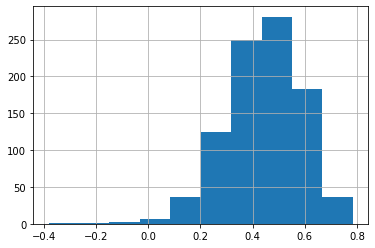

In [120]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe(0, 1, models).iloc[:,-1].hist()

Now I can store the full series of the cosine similarity between the embedding of a word in each macrogenre:

In [121]:
series = list()
series_df = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
df = cosine_similarity_dataframe(0, 1, models)
series_df[df.columns[0]] = df.iloc[:,0]
series_df[df.columns[1]] = df.iloc[:,1]
series_df[df.columns[2]] = df.iloc[:,2]
series_df[df.columns[3]] = df.iloc[:,3]

#    if i == reference_interval_index:
#        time_series_df = df
#        col_i = "interval-"+str(reference_interval_index)
#        time_series_df[col_i] = [reference_interval_index for w in models[reference_interval_index].wv.index_to_key]
#        col_n = "neighbours_ref-"+reference_step
#        time_series_df[col_n] = [models[reference_interval_index].wv.similar_by_word(w, 10) for w in models[reference_interval_index].wv.index_to_key]
#    else:
#        #time_series_df = time_series_df, df.iloc[:,-2:]
#        tmp_df = df.iloc[:,-2:]
#        #df.iloc[:,-2:].column[0]
#        #print(tmp_df.iloc[:,0])
#        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
#        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
#        col_i = "interval-"+str(i)
#        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
#        #Finding top 10 nearest neighbours:
#        col_n = "neighbours_t"+str(i)
#        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
series_df[4] = [models[0].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
series_df[5] = [models[1].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]

#series_df.columns[5] = "neighbours_model1"

series_df

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",4,5
0,et,182432,11466,0.767482,"[(atque, 0.5057729482650757), (autem, 0.489675...","[(super, 0.7761459350585938), (populus#2, 0.76..."
1,sum,166640,6871,0.750863,"[(habeo, 0.5785518884658813), (video, 0.532538...","[(invenio, 0.8076888918876648), (facio, 0.7860..."
2,in,111998,5877,0.636616,"[(ex, 0.48520132899284363), (ad, 0.48063868284...","[(universus, 0.69366455078125), (super, 0.6871..."
3,quis#2,101347,4902,0.784682,"[(quod, 0.7686824798583984), (qui, 0.659094810...","[(quis, 0.7623904347419739), (ut, 0.7230060100..."
4,is,89813,3218,0.627927,"[(ipse, 0.5443899631500244), (ille, 0.52470064...","[(iustus, 0.8418185710906982), (impius, 0.8361..."
...,...,...,...,...,...,...
916,vates,702,51,0.269062,"[(cano, 0.585236132144928), (dea, 0.5796818137...","[(posco, 0.9585827589035034), (tandem, 0.95562..."
917,purpureus,702,51,0.368263,"[(vestis, 0.7304768562316895), (aureus, 0.7168...","[(protinus, 0.9780449867248535), (frons, 0.970..."
918,Graius,702,51,0.392988,"[(tellus, 0.5094307065010071), (nemus, 0.50870...","[(clarus, 0.9607619047164917), (pendeo, 0.9590..."
919,gressus,701,51,0.452735,"[(cervix, 0.6808196902275085), (semita, 0.6220...","[(pulvis, 0.9555988311767578), (dens, 0.937267..."


I rename the last two columns:

In [122]:
't'+str(1)

't1'

In [123]:
series_df.columns=['neighbours_model'+macrogenres[0] if x==4 else x for x in series_df.columns]
series_df.columns=['neighbours_model'+macrogenres[1] if x==5 else x for x in series_df.columns]
series_df

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",neighbours_modelprose,neighbours_modelpoetry
0,et,182432,11466,0.767482,"[(atque, 0.5057729482650757), (autem, 0.489675...","[(super, 0.7761459350585938), (populus#2, 0.76..."
1,sum,166640,6871,0.750863,"[(habeo, 0.5785518884658813), (video, 0.532538...","[(invenio, 0.8076888918876648), (facio, 0.7860..."
2,in,111998,5877,0.636616,"[(ex, 0.48520132899284363), (ad, 0.48063868284...","[(universus, 0.69366455078125), (super, 0.6871..."
3,quis#2,101347,4902,0.784682,"[(quod, 0.7686824798583984), (qui, 0.659094810...","[(quis, 0.7623904347419739), (ut, 0.7230060100..."
4,is,89813,3218,0.627927,"[(ipse, 0.5443899631500244), (ille, 0.52470064...","[(iustus, 0.8418185710906982), (impius, 0.8361..."
...,...,...,...,...,...,...
916,vates,702,51,0.269062,"[(cano, 0.585236132144928), (dea, 0.5796818137...","[(posco, 0.9585827589035034), (tandem, 0.95562..."
917,purpureus,702,51,0.368263,"[(vestis, 0.7304768562316895), (aureus, 0.7168...","[(protinus, 0.9780449867248535), (frons, 0.970..."
918,Graius,702,51,0.392988,"[(tellus, 0.5094307065010071), (nemus, 0.50870...","[(clarus, 0.9607619047164917), (pendeo, 0.9590..."
919,gressus,701,51,0.452735,"[(cervix, 0.6808196902275085), (semita, 0.6220...","[(pulvis, 0.9555988311767578), (dens, 0.937267..."


In [124]:
series_df.to_csv(os.path.join(dir_out, 'semantic_variation_macrogenres_allwords.csv'), index=None)

In [125]:
series_df.describe

<bound method NDFrame.describe of           Word  Frequency_g1  Frequency_g2  Cosine_similarity(w_g1,w_g2)  \
0           et        182432         11466                      0.767482   
1          sum        166640          6871                      0.750863   
2           in        111998          5877                      0.636616   
3       quis#2        101347          4902                      0.784682   
4           is         89813          3218                      0.627927   
..         ...           ...           ...                           ...   
916      vates           702            51                      0.269062   
917  purpureus           702            51                      0.368263   
918     Graius           702            51                      0.392988   
919    gressus           701            51                      0.452735   
920        Iob           699            51                      0.402654   

                                 neighbours_modelpros

I rearrange the dataframe for visualization:

In [126]:
series_df.columns

Index(['Word', 'Frequency_g1', 'Frequency_g2', 'Cosine_similarity(w_g1,w_g2)',
       'neighbours_modelprose', 'neighbours_modelpoetry'],
      dtype='object')

In [127]:
series_df

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",neighbours_modelprose,neighbours_modelpoetry
0,et,182432,11466,0.767482,"[(atque, 0.5057729482650757), (autem, 0.489675...","[(super, 0.7761459350585938), (populus#2, 0.76..."
1,sum,166640,6871,0.750863,"[(habeo, 0.5785518884658813), (video, 0.532538...","[(invenio, 0.8076888918876648), (facio, 0.7860..."
2,in,111998,5877,0.636616,"[(ex, 0.48520132899284363), (ad, 0.48063868284...","[(universus, 0.69366455078125), (super, 0.6871..."
3,quis#2,101347,4902,0.784682,"[(quod, 0.7686824798583984), (qui, 0.659094810...","[(quis, 0.7623904347419739), (ut, 0.7230060100..."
4,is,89813,3218,0.627927,"[(ipse, 0.5443899631500244), (ille, 0.52470064...","[(iustus, 0.8418185710906982), (impius, 0.8361..."
...,...,...,...,...,...,...
916,vates,702,51,0.269062,"[(cano, 0.585236132144928), (dea, 0.5796818137...","[(posco, 0.9585827589035034), (tandem, 0.95562..."
917,purpureus,702,51,0.368263,"[(vestis, 0.7304768562316895), (aureus, 0.7168...","[(protinus, 0.9780449867248535), (frons, 0.970..."
918,Graius,702,51,0.392988,"[(tellus, 0.5094307065010071), (nemus, 0.50870...","[(clarus, 0.9607619047164917), (pendeo, 0.9590..."
919,gressus,701,51,0.452735,"[(cervix, 0.6808196902275085), (semita, 0.6220...","[(pulvis, 0.9555988311767578), (dens, 0.937267..."


List of socio-political terms:

In [128]:
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator", "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]

In [129]:
series_df_socpol = series_df[series_df['Word'].isin(socio_political_terms)]
series_df_socpol.to_csv(os.path.join(dir_out, 'semantic_variation_macrogenres_socpolwords.csv'), index=None) 
series_df_socpol

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",neighbours_modelprose,neighbours_modelpoetry
59,imperator,9533,530,0.111774,"[(papa, 0.31338000297546387), (Caesar, 0.29832...","[(pontifex, 0.9303296208381653), (igitur, 0.91..."
93,urbs,6576,354,0.489287,"[(civitas, 0.7204551696777344), (arx, 0.609270...","[(classis, 0.9284762740135193), (murus, 0.9167..."
115,civitas,5379,308,0.493805,"[(urbs, 0.7204550504684448), (regio, 0.5426530...","[(iuxta, 0.9552202820777893), (Ravenna, 0.9519..."
116,populus,5335,308,0.468930,"[(populus#2, 0.7757981419563293), (civis, 0.58...","[(Sion, 0.9123147130012512), (universus, 0.892..."
118,hostis,5294,306,0.378211,"[(acies, 0.584151566028595), (proelium, 0.5446...","[(pes, 0.8931417465209961), (pulvis, 0.8879168..."
161,jus,3884,231,0.240549,"[(lex, 0.5225710272789001), (iudicium, 0.42458...","[(femina, 0.9053559899330139), (colo, 0.902435..."
163,gens,3872,230,0.543154,"[(regio, 0.5820664763450623), (civitas, 0.4974...","[(caelum, 0.8982587456703186), (terra, 0.89330..."
173,regnum,3643,221,0.346119,"[(rex, 0.5743542909622192), (imperium, 0.54349...","[(templum, 0.9216991066932678), (aula, 0.91840..."
184,consilium,3390,211,0.318403,"[(res, 0.4400726556777954), (iudicium, 0.41176...","[(cogitatio, 0.9546533226966858), (considero, ..."
204,dux,3083,187,0.251380,"[(comes, 0.553273618221283), (princeps, 0.5295...","[(divus, 0.9567061066627502), (posco, 0.933878..."


In [68]:
series_df_socpol = series_df[series_df['Word'].isin(socio_political_terms)]
series_df_socpol.to_csv(os.path.join(dir_out, 'semantic_variation_macrogenres_socpolwords.csv'), index=None) 
series_df_socpol

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",neighbours_modelprose,neighbours_modelpoetry
59,imperator,9533,530,0.111774,"[(papa, 0.31338000297546387), (Caesar, 0.29832...","[(pontifex, 0.9303296208381653), (igitur, 0.91..."
93,urbs,6576,354,0.489287,"[(civitas, 0.7204551696777344), (arx, 0.609270...","[(classis, 0.9284762740135193), (murus, 0.9167..."
115,civitas,5379,308,0.493805,"[(urbs, 0.7204550504684448), (regio, 0.5426530...","[(iuxta, 0.9552202820777893), (Ravenna, 0.9519..."
116,populus,5335,308,0.468930,"[(populus#2, 0.7757981419563293), (civis, 0.58...","[(Sion, 0.9123147130012512), (universus, 0.892..."
118,hostis,5294,306,0.378211,"[(acies, 0.584151566028595), (proelium, 0.5446...","[(pes, 0.8931417465209961), (pulvis, 0.8879168..."
161,jus,3884,231,0.240549,"[(lex, 0.5225710272789001), (iudicium, 0.42458...","[(femina, 0.9053559899330139), (colo, 0.902435..."
163,gens,3872,230,0.543154,"[(regio, 0.5820664763450623), (civitas, 0.4974...","[(caelum, 0.8982587456703186), (terra, 0.89330..."
173,regnum,3643,221,0.346119,"[(rex, 0.5743542909622192), (imperium, 0.54349...","[(templum, 0.9216991066932678), (aula, 0.91840..."
184,consilium,3390,211,0.318403,"[(res, 0.4400726556777954), (iudicium, 0.41176...","[(cogitatio, 0.9546533226966858), (considero, ..."
204,dux,3083,187,0.251380,"[(comes, 0.553273618221283), (princeps, 0.5295...","[(divus, 0.9567061066627502), (posco, 0.933878..."


## Historiography subcorpus

I select by time period before 800CE and historical genre:

In [69]:
historical_texts = ['LAT0142', 'LAT0240', 'LAT0241', 'LAT0529', 'LAT0242', 'LAT0849', 'LAT0996', 'LAT0883', 'LAT0148',
                  'LAT0325', 'LAT0278', 'LAT0120', 'LAT1040', 'LAT0720', 'LAT0534', 'LAT0054', 'LAT0846', 'LAT0665',
                  'LAT0201', 'LAT0471', 'LAT0896', 'LAT0959', 'LAT0351', 'LAT0115', 'LAT0612', 'LAT0776', 'LAT0850',
                  'LAT0238', 'LAT0121', 'LAT0726', 'LAT0878', 'LAT1001', 'LAT0410', 'LAT0791', 'LAT0196', 'LAT0906',
                  'LAT0783', 'LAT0909', 'LAT0785', 'LAT0338', 'LAT0936', 'LAT0792', 'LAT0494', 'LAT0459']
historical_texts = ['IT-'+f for f in historical_texts]
historical_texts

['IT-LAT0142',
 'IT-LAT0240',
 'IT-LAT0241',
 'IT-LAT0529',
 'IT-LAT0242',
 'IT-LAT0849',
 'IT-LAT0996',
 'IT-LAT0883',
 'IT-LAT0148',
 'IT-LAT0325',
 'IT-LAT0278',
 'IT-LAT0120',
 'IT-LAT1040',
 'IT-LAT0720',
 'IT-LAT0534',
 'IT-LAT0054',
 'IT-LAT0846',
 'IT-LAT0665',
 'IT-LAT0201',
 'IT-LAT0471',
 'IT-LAT0896',
 'IT-LAT0959',
 'IT-LAT0351',
 'IT-LAT0115',
 'IT-LAT0612',
 'IT-LAT0776',
 'IT-LAT0850',
 'IT-LAT0238',
 'IT-LAT0121',
 'IT-LAT0726',
 'IT-LAT0878',
 'IT-LAT1001',
 'IT-LAT0410',
 'IT-LAT0791',
 'IT-LAT0196',
 'IT-LAT0906',
 'IT-LAT0783',
 'IT-LAT0909',
 'IT-LAT0785',
 'IT-LAT0338',
 'IT-LAT0936',
 'IT-LAT0792',
 'IT-LAT0494',
 'IT-LAT0459']

In [70]:
len(historical_texts)

44

Add a column to the metadata_df for the historical texts:

In [71]:
metadata_df_hist = metadata_df
metadata_df_hist['historical'] = np.where(metadata_df["id"].isin(historical_texts), "historical", "non-historical")
metadata_df_hist

,id,title,creator,date,type,file,Unnamed: 6,historical
18,IT-LAT0001,Vulgata VT Genesis,Hieronymus,382,prose,lat_0382_IT-LAT0001.txt,1.0,non-historical
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,NaN,non-historical
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,NaN,non-historical
23,IT-LAT0015,Confessiones,"Augustinus, Aurelius",399,prose,lat_0399_IT-LAT0015.txt,NaN,non-historical
24,IT-LAT0016,Regula,"Augustinus, Aurelius",391,prose,lat_0391_IT-LAT0016.txt,NaN,non-historical
...,...,...,...,...,...,...,...,...
683,IT-LAT0534_1,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_1.txt,NaN,non-historical
684,IT-LAT0534_2,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_2.txt,NaN,non-historical
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,NaN,non-historical
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,NaN,non-historical


In [72]:
metadata_df_hist.describe

<bound method NDFrame.describe of                 id                          title  \
18      IT-LAT0001             Vulgata VT Genesis   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
23      IT-LAT0015                   Confessiones   
24      IT-LAT0016                         Regula   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382   prose   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
23                                 Au

In [73]:
metadata_df_hist.groupby(['historical']).count()

,id,title,creator,date,type,file,Unnamed: 6
historical,,,,,,,
historical,42,42,42,42,42,42,0
non-historical,343,343,343,343,343,343,16


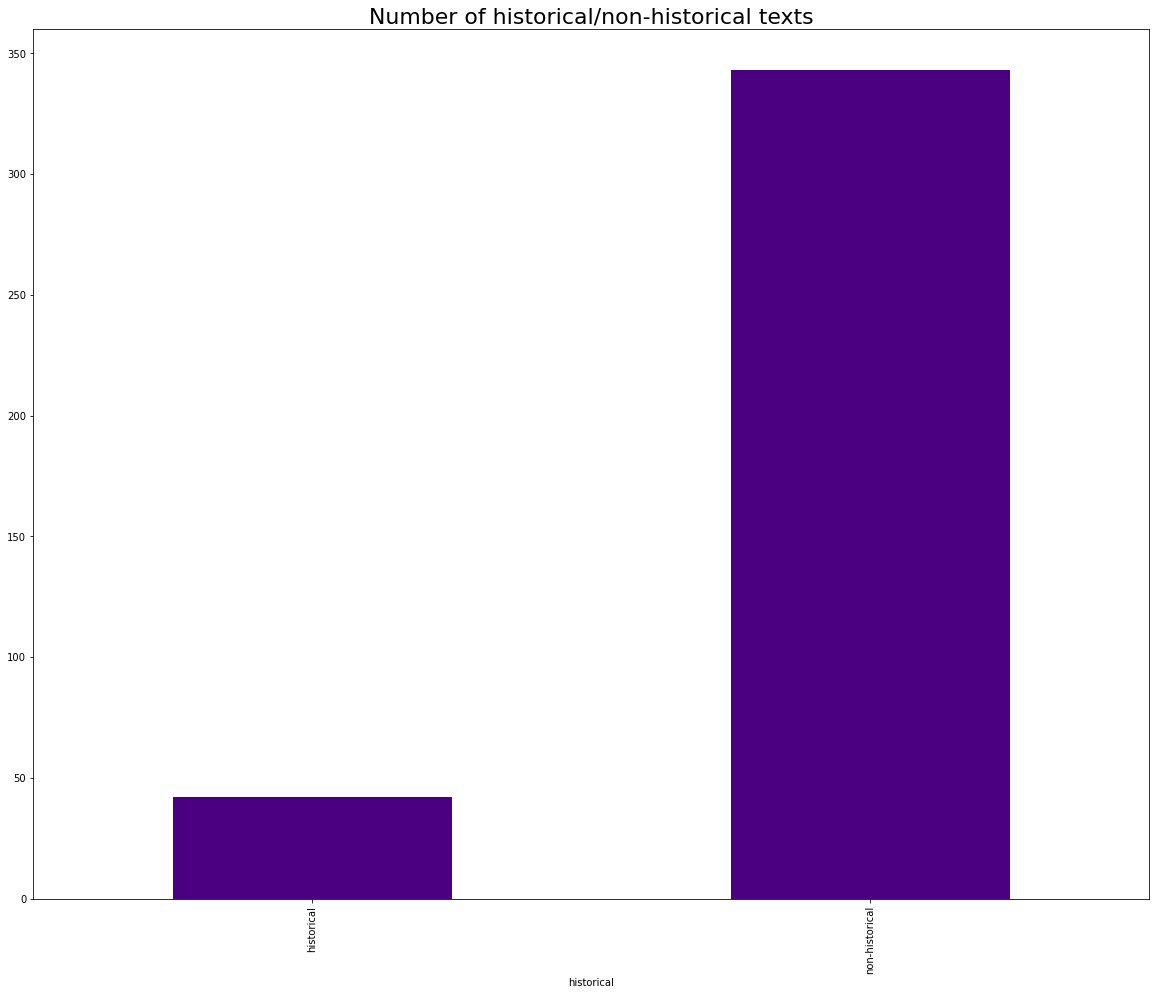

In [74]:
metadata_df_hist0 = metadata_df_hist.groupby(['historical']).count()
metadata_df_hist0 = metadata_df_hist0['id']
metadata_df_hist0
ax = metadata_df_hist0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of historical/non-historical texts", fontsize=22)
plt.show()

In [75]:
metadata_df_hist0

historical
historical         42
non-historical    343
Name: id, dtype: int64

## Training embeddings for each domain (historical/non-historical)

In [76]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
domain2corpus = dict()
domains = ['historical', 'non-historical']

# I loop over all macro-genres:
for d in range(len(domains)):
    print("domain:", domains[d])
    files_corpus_d = metadata_df_hist.loc[metadata_df['historical'] == domains[d]]
    #print("1:",files_corpus_g, type(files_corpus_g))
    corpus_d = list()
    for index, df_line in files_corpus_d.iterrows():
        #print("line:",df_line['id'], df_line['type'])
        count = 0
        for filename in files:
            count = count + 1
            if df_line['id']+'.txt' in filename and df_line['historical'] == domains[d]:# and count<10:
                #print(df_line['type'], "file!", filename)
                file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, filename), 'r')
                sentences_this_file = list()
                while True:
                    line = file.readline().strip()
                    #print(line[1:50])
                    if line != "":
                        corpus_d.append([token for token in line.split(" ") if token not in punctuation])
                    if not line:
                        break
                file.close()
    domain2corpus[d] = corpus_d
    #print(macrogenre2corpus[g][0:10])


domain: historical
domain: non-historical


In [77]:
print(len(domain2corpus[0]))
print(len(domain2corpus[1]))

69224
249116


In [78]:
domain2corpus[0]

[['vita',
  'DIVI',
  'IVLI',
  'annus',
  'agens',
  'sextus',
  'decimus',
  'pater',
  'amitto',
  'sequentibusque',
  'consul',
  'flamen',
  'Dialis',
  'destinatus',
  'dimitto',
  'Cossutius',
  'quis#2',
  'familia',
  'equester',
  'sed',
  'admodum',
  'dives',
  'praetextatus',
  'desponsor',
  'sum',
  'Cornelius',
  'Cinna',
  'quater',
  'consul',
  'filia',
  'duco',
  'uxor',
  'ex',
  'qui',
  'ille',
  'mox',
  'Iulia',
  'nascor',
  'sum',
  'neque',
  'ut',
  'repudio',
  'compelli',
  'ab',
  'dictator',
  'Sulla',
  'ullus',
  'modus',
  'possum'],
 ['quare',
  'et',
  'sacerdotium',
  'et',
  'uxor',
  'dos',
  'et',
  'gentilicis',
  'hereditas',
  'multo',
  'diuersarum',
  'pars',
  'habeo',
  'ut',
  'etiam',
  'discedo',
  'ex',
  'medius',
  'et',
  'quamquam',
  'morbus',
  'quartana',
  'adgrauante',
  'prope',
  'per',
  'singulus',
  'nox',
  'commuto',
  'latebra',
  'cogo',
  'se',
  'ab',
  'inquisitoribus',
  'pecunia',
  'redimo',
  'donec',
  'per

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each macrogenre I train a fasttext model:

I now train one model for each domain:

In [79]:
len(domain2corpus)

2

In [80]:
models_domains = list()
start = time.time()
for d in range(len(domain2corpus)):
    if len(domain2corpus[d])>0:
        print(d)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0)  # instantiate
        model.build_vocab(corpus_iterable=domain2corpus[d])
        model.train(corpus_iterable=domain2corpus[d], total_examples=len(domain2corpus[d]), epochs=10)  # train
        models_domains.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
It has taken 60 seconds, or  1 minutes


Let's check some models:

In [81]:
print_vocab(models_domains[0], 20)

word #0/3162 is et
word #1/3162 is sum
word #2/3162 is in
word #3/3162 is is
word #4/3162 is quis#2
word #5/3162 is ad
word #6/3162 is cum
word #7/3162 is ab
word #8/3162 is ut
word #9/3162 is hic
word #10/3162 is se
word #11/3162 is non
word #12/3162 is suus
word #13/3162 is atque
word #14/3162 is ex
word #15/3162 is omnis
word #16/3162 is quod
word #17/3162 is quam#4
word #18/3162 is ipse


In [82]:
models_domains[0].wv.similar_by_word('dies', 10)

[('biduum', 0.5855982303619385),
 ('triduum', 0.5755044221878052),
 ('mensis', 0.5366657376289368),
 ('hora', 0.5297061204910278),
 ('vigilia', 0.4734784662723541),
 ('annus', 0.4337473213672638),
 ('nox', 0.42989227175712585),
 ('triennium', 0.39441391825675964),
 ('Idus', 0.3836945593357086),
 ('tempus', 0.37202659249305725)]

In [83]:
print_vocab(models_domains[1], 20)

word #0/5427 is et
word #1/5427 is sum
word #2/5427 is in
word #3/5427 is quis#2
word #4/5427 is is
word #5/5427 is non
word #6/5427 is hic
word #7/5427 is ab
word #8/5427 is ut
word #9/5427 is ad
word #10/5427 is cum
word #11/5427 is si
word #12/5427 is quod
word #13/5427 is ille
word #14/5427 is dico#2
word #15/5427 is omnis
word #16/5427 is de
word #17/5427 is sed
word #18/5427 is suus


In [84]:
models_domains[1].wv.similar_by_word('dies', 10)

[('hora', 0.7009413242340088),
 ('septimana', 0.6743130683898926),
 ('annus', 0.644425094127655),
 ('mensis', 0.5718143582344055),
 ('sabbatum', 0.565684974193573),
 ('feriae', 0.5357481241226196),
 ('triduus', 0.5201606750488281),
 ('pascha', 0.5119320750236511),
 ('nox', 0.5052574276924133),
 ('quadragesimus', 0.49307870864868164)]

##  Embedding space alignment

Now I can apply the function to my models:

In [85]:
smart_procrustes_align_gensim(models_domains[1], models_domains[0])

2819 2819
2819 2819
['et', 'sum', 'in', 'quis#2', 'is', 'non', 'hic', 'ab', 'ad', 'ut', 'cum', 'quod', 'si', 'ille', 'omnis', 'suus', 'dico#2', 'sed', 'ex', 'de', 'atque', 'se', 'ipse', 'facio', 'possum', 'quam#4', 'ego', 'aut', 'res', 'per', 'autem', 'habeo', 'enim', 'alius', 'nec', 'multus', 'deus', 'video', 'etiam', 'vel', 'tu', 'qui', 'idem', 'do', 'rex', 'tuus', 'filius', 'homo', 'verus', 'ne#2', 'quo', 'dies', 'dominus', "'", 'magnus', 'unus', 'meus', 'locus', 'nos', 'ita', 'imperator', 'quia', 'tamen', 'tempus', 'iam', 'causa', 'venio', 'noster', 'neque', 'modus', 'pars', 'primus', 'bonus', 'pater', 'pro', 'quoque', 'quidem', 'quidam', 'Romanus', 'vos', 'inter', 'post', 'nomen', '-', 'nihil', 'nullus', 'tantus', 'aliquis', 'bellum', 'annus', 'vir', 'animus', 'ago', 'terra', 'urbs', 'fio', 'verbum', 'debeo', 'publicus', 'nisi', 'iste', 'ante', 'duo', 'mitto', 'corpus', 'lex', 'sine', 'genus', 'sic', 'accipio', 'manus', 'audio', 'consul', 'ubi', 'parvus', 'volo#1', 'apud', 'exerci

I align all models:

In [86]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models_domains)-1):
    reduce(smart_procrustes_align_gensim, models_domains)
    

Now the models have been aligned and have the same vocabulary:

In [87]:
for i in range(0,len(models_domains)):
    print(i, len(models_domains[i].wv.index_to_key))

0 2819
1 2819


# Semantic variation with cosine similarity

In [88]:
models_domains

In [89]:
cosine_similarity("sum", 1, 0, models_domains)

0.6978943347930908

In [90]:
cosine_similarity("sum", 0,1, models_domains)

0.6978943347930908

In [91]:
cosine_similarity_dataframe(0, 1, models_domains)

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)"
0,et,42182,151716,0.684795
1,sum,39738,133773,0.697894
2,in,33002,84873,0.704826
3,quis#2,24153,82193,0.776211
4,is,24056,68878,0.754529
...,...,...,...,...
2814,Penates,59,136,0.520542
2815,saepio,59,136,0.728982
2816,Numa,59,136,0.623861
2817,Demetrius,59,136,0.453114


Visualise the distribution of the semantic similarity scores with a histogram:

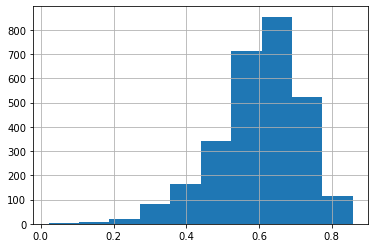

In [92]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe(0, 1, models_domains).iloc[:,-1].hist()

Now I can store the full series of the cosine similarity between the embedding of a word in each macrogenre:

In [93]:
series_domains = list()
series_domains_df = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
df_domains = cosine_similarity_dataframe(0, 1, models_domains)
series_domains_df[df_domains.columns[0]] = df_domains.iloc[:,0]
series_domains_df[df_domains.columns[1]] = df_domains.iloc[:,1]
series_domains_df[df_domains.columns[2]] = df_domains.iloc[:,2]
series_domains_df[df_domains.columns[3]] = df_domains.iloc[:,3]

#    if i == reference_interval_index:
#        time_series_df = df
#        col_i = "interval-"+str(reference_interval_index)
#        time_series_df[col_i] = [reference_interval_index for w in models[reference_interval_index].wv.index_to_key]
#        col_n = "neighbours_ref-"+reference_step
#        time_series_df[col_n] = [models[reference_interval_index].wv.similar_by_word(w, 10) for w in models[reference_interval_index].wv.index_to_key]
#    else:
#        #time_series_df = time_series_df, df.iloc[:,-2:]
#        tmp_df = df.iloc[:,-2:]
#        #df.iloc[:,-2:].column[0]
#        #print(tmp_df.iloc[:,0])
#        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
#        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
#        col_i = "interval-"+str(i)
#        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
#        #Finding top 10 nearest neighbours:
#        col_n = "neighbours_t"+str(i)
#        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
series_domains_df[4] = [models_domains[0].wv.similar_by_word(w, 10) for w in models_domains[i].wv.index_to_key]
series_domains_df[5] = [models_domains[1].wv.similar_by_word(w, 10) for w in models_domains[i].wv.index_to_key]

#series_df.columns[5] = "neighbours_model1"

series_domains_df

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",4,5
0,et,42182,151716,0.684795,"[(atque, 0.3965279459953308), (item, 0.3688066...","[(cumque, 0.4949180483818054), (sicut, 0.48010..."
1,sum,39738,133773,0.697894,"[(consto, 0.5068989992141724), (fio, 0.4746660...","[(appareo, 0.506169319152832), (habeo, 0.50128..."
2,in,33002,84873,0.704826,"[(extra, 0.43000903725624084), (ex, 0.41541072...","[(super, 0.5115347504615784), (ex, 0.446893692..."
3,quis#2,24153,82193,0.776211,"[(quos, 0.544116199016571), (quod, 0.524349510...","[(quod, 0.7143561840057373), (qui, 0.589138031..."
4,is,24056,68878,0.754529,"[(suus, 0.448130339384079), (Philippus, 0.3822...","[(suus, 0.4887993633747101), (hic, 0.468731164..."
...,...,...,...,...,...,...
2814,Penates,59,136,0.520542,"[(tutela, 0.6579330563545227), (incolumis, 0.5...","[(limen, 0.6921541690826416), (celsus, 0.60480..."
2815,saepio,59,136,0.728982,"[(cingo, 0.8328842520713806), (munio, 0.808851...","[(circum, 0.7281193137168884), (agger, 0.71579..."
2816,Numa,59,136,0.623861,"[(Romulus, 0.7065490484237671), (Augustus#2, 0...","[(Romulus, 0.6995991468429565), (Cyrus, 0.5938..."
2817,Demetrius,59,136,0.453114,"[(soror, 0.6552736759185791), (cognatus, 0.618...","[(Antiochus, 0.7005929946899414), (Cyrus, 0.60..."


I rename the last two columns:

In [94]:
series_domains_df.columns=['neighbours_model_histmodel'+domains[0] if x==4 else x for x in series_domains_df.columns]
series_domains_df.columns=['neighbours_model_histmodel'+domains[1] if x==5 else x for x in series_domains_df.columns]
series_domains_df

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",neighbours_model_histmodelhistorical,neighbours_model_histmodelnon-historical
0,et,42182,151716,0.684795,"[(atque, 0.3965279459953308), (item, 0.3688066...","[(cumque, 0.4949180483818054), (sicut, 0.48010..."
1,sum,39738,133773,0.697894,"[(consto, 0.5068989992141724), (fio, 0.4746660...","[(appareo, 0.506169319152832), (habeo, 0.50128..."
2,in,33002,84873,0.704826,"[(extra, 0.43000903725624084), (ex, 0.41541072...","[(super, 0.5115347504615784), (ex, 0.446893692..."
3,quis#2,24153,82193,0.776211,"[(quos, 0.544116199016571), (quod, 0.524349510...","[(quod, 0.7143561840057373), (qui, 0.589138031..."
4,is,24056,68878,0.754529,"[(suus, 0.448130339384079), (Philippus, 0.3822...","[(suus, 0.4887993633747101), (hic, 0.468731164..."
...,...,...,...,...,...,...
2814,Penates,59,136,0.520542,"[(tutela, 0.6579330563545227), (incolumis, 0.5...","[(limen, 0.6921541690826416), (celsus, 0.60480..."
2815,saepio,59,136,0.728982,"[(cingo, 0.8328842520713806), (munio, 0.808851...","[(circum, 0.7281193137168884), (agger, 0.71579..."
2816,Numa,59,136,0.623861,"[(Romulus, 0.7065490484237671), (Augustus#2, 0...","[(Romulus, 0.6995991468429565), (Cyrus, 0.5938..."
2817,Demetrius,59,136,0.453114,"[(soror, 0.6552736759185791), (cognatus, 0.618...","[(Antiochus, 0.7005929946899414), (Cyrus, 0.60..."


In [95]:
series_domains_df.to_csv(os.path.join(dir_out, 'semantic_variation_domains_allwords.csv'), index=None)

In [96]:
series_domains_df.describe

<bound method NDFrame.describe of            Word  Frequency_g1  Frequency_g2  Cosine_similarity(w_g1,w_g2)  \
0            et         42182        151716                      0.684795   
1           sum         39738        133773                      0.697894   
2            in         33002         84873                      0.704826   
3        quis#2         24153         82193                      0.776211   
4            is         24056         68878                      0.754529   
...         ...           ...           ...                           ...   
2814    Penates            59           136                      0.520542   
2815     saepio            59           136                      0.728982   
2816       Numa            59           136                      0.623861   
2817  Demetrius            59           136                      0.453114   
2818   perpetro            59           136                      0.338246   

                   neighbours_model_histm

I rearrange the dataframe for visualization:

In [97]:
series_domains_df.columns

Index(['Word', 'Frequency_g1', 'Frequency_g2', 'Cosine_similarity(w_g1,w_g2)',
       'neighbours_model_histmodelhistorical',
       'neighbours_model_histmodelnon-historical'],
      dtype='object')

In [98]:
series_domains_df

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",neighbours_model_histmodelhistorical,neighbours_model_histmodelnon-historical
0,et,42182,151716,0.684795,"[(atque, 0.3965279459953308), (item, 0.3688066...","[(cumque, 0.4949180483818054), (sicut, 0.48010..."
1,sum,39738,133773,0.697894,"[(consto, 0.5068989992141724), (fio, 0.4746660...","[(appareo, 0.506169319152832), (habeo, 0.50128..."
2,in,33002,84873,0.704826,"[(extra, 0.43000903725624084), (ex, 0.41541072...","[(super, 0.5115347504615784), (ex, 0.446893692..."
3,quis#2,24153,82193,0.776211,"[(quos, 0.544116199016571), (quod, 0.524349510...","[(quod, 0.7143561840057373), (qui, 0.589138031..."
4,is,24056,68878,0.754529,"[(suus, 0.448130339384079), (Philippus, 0.3822...","[(suus, 0.4887993633747101), (hic, 0.468731164..."
...,...,...,...,...,...,...
2814,Penates,59,136,0.520542,"[(tutela, 0.6579330563545227), (incolumis, 0.5...","[(limen, 0.6921541690826416), (celsus, 0.60480..."
2815,saepio,59,136,0.728982,"[(cingo, 0.8328842520713806), (munio, 0.808851...","[(circum, 0.7281193137168884), (agger, 0.71579..."
2816,Numa,59,136,0.623861,"[(Romulus, 0.7065490484237671), (Augustus#2, 0...","[(Romulus, 0.6995991468429565), (Cyrus, 0.5938..."
2817,Demetrius,59,136,0.453114,"[(soror, 0.6552736759185791), (cognatus, 0.618...","[(Antiochus, 0.7005929946899414), (Cyrus, 0.60..."


Print to output file:

In [103]:
series_domains_df.to_csv(os.path.join(dir_out, 'semantic_variation_domains_allwords.csv'), index=None) 

List of socio-political terms:

In [100]:
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator", "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]

In [101]:
series_domains_df_socpol = series_domains_df[series_domains_df['Word'].isin(socio_political_terms)]
series_domains_df_socpol.to_csv(os.path.join(dir_out, 'semantic_variation_domains_socpolwords.csv'), index=None) 
series_domains_df_socpol

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",neighbours_model_histmodelhistorical,neighbours_model_histmodelnon-historical
60,imperator,2871,7473,0.409849,"[(dux, 0.6008662581443787), (ductor, 0.5291066...","[(Honorius, 0.47663503885269165), (Valentinian..."
94,urbs,1970,4972,0.663487,"[(oppidum, 0.6755664944648743), (civitas, 0.61...","[(civitas, 0.7247748970985413), (oppidum, 0.69..."
112,consul,1688,4115,0.687660,"[(praetor, 0.6975811719894409), (collega, 0.66...","[(dictator, 0.6990735530853271), (Marius, 0.69..."
118,civitas,1589,3993,0.685525,"[(urbs, 0.6144320964813232), (urbibus, 0.57851...","[(urbs, 0.7247750759124756), (urbibus, 0.57080..."
119,populus,1576,3972,0.686511,"[(populus#2, 0.6778554320335388), (civis, 0.48...","[(populus#2, 0.7882602214813232), (civis, 0.56..."
121,hostis,1543,3891,0.629840,"[(hostus, 0.638231635093689), (adversarius, 0....","[(hostus, 0.7421262264251709), (proelium, 0.70..."
155,senatus,1288,3096,0.605837,"[(collegium, 0.5951616764068604), (decretum, 0...","[(magistratus, 0.6250279545783997), (contio, 0..."
167,jus,1209,2852,0.715139,"[(ius, 0.7541096210479736), (lex, 0.7159630656...","[(ius, 0.7584900856018066), (edictum, 0.567358..."
169,gens,1206,2792,0.724802,"[(natio, 0.6866438984870911), (Persa, 0.543274...","[(natio, 0.7985187768936157), (Francus, 0.5461..."
179,regnum,1172,2651,0.612686,"[(principatus, 0.62319016456604), (regno, 0.60...","[(gens, 0.5279143452644348), (imperium, 0.5038..."


In [102]:
series_domains_df_socpol = series_domains_df[series_domains_df['Word'].isin(socio_political_terms)]
series_domains_df_socpol.to_csv(os.path.join(dir_out, 'semantic_variation_domains_socpolwords.csv'), index=None) 
series_domains_df_socpol

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",neighbours_model_histmodelhistorical,neighbours_model_histmodelnon-historical
60,imperator,2871,7473,0.409849,"[(dux, 0.6008662581443787), (ductor, 0.5291066...","[(Honorius, 0.47663503885269165), (Valentinian..."
94,urbs,1970,4972,0.663487,"[(oppidum, 0.6755664944648743), (civitas, 0.61...","[(civitas, 0.7247748970985413), (oppidum, 0.69..."
112,consul,1688,4115,0.687660,"[(praetor, 0.6975811719894409), (collega, 0.66...","[(dictator, 0.6990735530853271), (Marius, 0.69..."
118,civitas,1589,3993,0.685525,"[(urbs, 0.6144320964813232), (urbibus, 0.57851...","[(urbs, 0.7247750759124756), (urbibus, 0.57080..."
119,populus,1576,3972,0.686511,"[(populus#2, 0.6778554320335388), (civis, 0.48...","[(populus#2, 0.7882602214813232), (civis, 0.56..."
121,hostis,1543,3891,0.629840,"[(hostus, 0.638231635093689), (adversarius, 0....","[(hostus, 0.7421262264251709), (proelium, 0.70..."
155,senatus,1288,3096,0.605837,"[(collegium, 0.5951616764068604), (decretum, 0...","[(magistratus, 0.6250279545783997), (contio, 0..."
167,jus,1209,2852,0.715139,"[(ius, 0.7541096210479736), (lex, 0.7159630656...","[(ius, 0.7584900856018066), (edictum, 0.567358..."
169,gens,1206,2792,0.724802,"[(natio, 0.6866438984870911), (Persa, 0.543274...","[(natio, 0.7985187768936157), (Francus, 0.5461..."
179,regnum,1172,2651,0.612686,"[(principatus, 0.62319016456604), (regno, 0.60...","[(gens, 0.5279143452644348), (imperium, 0.5038..."
